# Train the semantic classifier

In [1]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from semantics.train import Trainer, TrainerConfig
from semantics.classifiers import ResNet50

# --- Model ---
classifier = ResNet50(
        num_classes=10, 
        in_channels=3, 
        pretrained=True, 
        freeze_backbone=False, 
        dropout=0.2
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = classifier.to(device)

# --- Data ---
img_size = 32
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616)),
])

train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
val_ds = datasets.CIFAR10("./data", train=False, download=True, transform=transform)

pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=pin)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=4, pin_memory=pin)

# --- Optimizer / Loss / Metrics ---
optimizer = AdamW(classifier.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()
def accuracy(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

metrics = {
    "acc": accuracy,
}

cfg = TrainerConfig(
    num_epochs=5,
    use_amp=True,
    task="supervised",
    amp_dtype="auto",
    grad_accum_steps=1,
    clip_grad_norm=1.0,
    compile_model=False,
    ckpt_path="../checkpoints/resnet_classifier.pt"
)

trainer = Trainer(
    pipeline=classifier,       # your model
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=criterion,         
    config=cfg,
    metrics=metrics,
)

trainer.train()


[epoch 000] epoch=0.0000 train_loss=0.8965 val_loss=0.5532 val_acc=0.8242


[epoch 001] epoch=1.0000 train_loss=0.3814 val_loss=0.4050 val_acc=0.8612


[epoch 002] epoch=2.0000 train_loss=0.2253 val_loss=0.4444 val_acc=0.8609


[epoch 003] epoch=3.0000 train_loss=0.1468 val_loss=0.4522 val_acc=0.8668


[epoch 004] epoch=4.0000 train_loss=0.1077 val_loss=0.4828 val_acc=0.8686


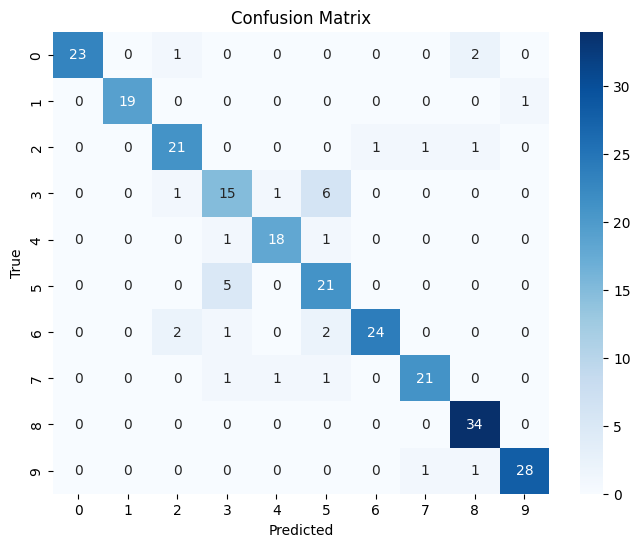

In [2]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Switch to evaluation mode
classifier.eval()

# Example: Make predictions on the validation set
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = classifier(images)
        preds = outputs.argmax(dim=1)
        break  # Remove this break to process the entire validation set

# Get true labels for the batch shown in preds
_, targets = next(iter(val_loader))
targets = targets.to(device)

# Compute confusion matrix
cm = confusion_matrix(targets.cpu().numpy(), preds.cpu().numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()